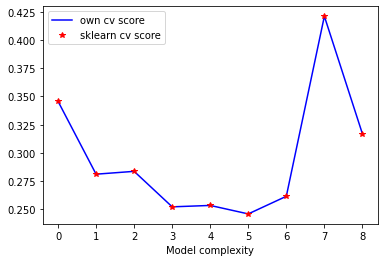

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

RANDOMSTATE = 42

np.random.seed(RANDOMSTATE)

max_degree = 9
datapoints = 50
num_kfolds = 10
noise = 0.5

def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2)) 
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

def create_X(x, y, n):
	if len(x.shape) > 1:
		x = np.ravel(x)
		y = np.ravel(y)

	N = len(x)
	l = int((n+1)*(n+2)/2)		# Number of elements in beta
	X = np.ones((N,l))

	for i in range(1,n+1):
		q = int((i)*(i+1)/2)
		for k in range(i+1):
			X[:,q+k] = (x**(i-k))*(y**k)

	return X

# Setting up the data
x = np.linspace(0, 1, datapoints)
y = np.linspace(0, 1, datapoints)
x, y = np.meshgrid(x, y)
z = FrankeFunction(x, y)
z += noise * np.random.randn(z.shape[0], z.shape[1])

# Storing the error, variance and bias
cv_score = np.zeros(max_degree)
cv_sklearn = np.zeros(max_degree)

kfold = KFold(num_kfolds)

# own code
for degree in range(max_degree):
    X = create_X(x, y, degree)

    mse_values = np.zeros(num_kfolds)
    i = 0

    for train_idx, test_idx in kfold.split(X):
        X_train = X[train_idx]
        X_test = X[test_idx]
        z_train = z.reshape(-1, 1)[train_idx]
        z_test = z.reshape(-1, 1)[test_idx]

        beta = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ z_train
        z_pred = X_test @ beta

        mse_values[i] = mean_squared_error(z_test, z_pred)
        i += 1

    cv_score[degree] = np.mean(mse_values)

# sklearn
for degree in range(max_degree):
    X = create_X(x, y, degree)

    cv_sklearn[degree] = -np.mean(cross_val_score(LinearRegression(fit_intercept=False), X, z.reshape(-1, 1), scoring='neg_mean_squared_error', cv=kfold))

fig, ax = plt.subplots()
ax.plot(range(max_degree), cv_score, 'b', label='own cv score')
ax.plot(range(max_degree), cv_sklearn, 'r*', label='sklearn cv score')
ax.set_xlabel('Model complexity')
ax.legend()
plt.show()